In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet201
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SIZE = 224  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/Data2/Train/*"): #Train Path
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)   
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

Healthy Nails
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN147.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN22.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN16.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN19.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN14.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN17.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN13.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN20.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN21.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN18.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN15.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN2.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN23.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN26.jpg
/content/drive/MyDrive/Data2/Train/Healthy Nails/healthyN24.jpg
/content/drive/MyDrive/Dat

In [ ]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/Data2/Test/*"): #Test Path
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

In [ ]:
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
#Rename (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded
x_train, y_train, x_test, y_test

(array([[[[132,  32,  30],
          [131,  31,  29],
          [131,  33,  27],
          ...,
          [128,  78,  87],
          [123,  75,  83],
          [119,  72,  80]],
 
         [[134,  35,  32],
          [132,  35,  31],
          [134,  37,  31],
          ...,
          [128,  78,  87],
          [123,  76,  84],
          [120,  74,  81]],
 
         [[134,  38,  32],
          [133,  38,  32],
          [134,  40,  33],
          ...,
          [130,  80,  89],
          [126,  79,  87],
          [122,  77,  84]],
 
         ...,
 
         [[168, 100,  99],
          [166,  98,  98],
          [165,  97,  96],
          ...,
          [ 44,  40,  37],
          [ 46,  42,  39],
          [ 48,  44,  41]],
 
         [[167,  99,  98],
          [165,  98,  97],
          [165,  96,  95],
          ...,
          [ 47,  44,  40],
          [ 50,  46,  43],
          [ 52,  48,  45]],
 
         [[168, 100,  99],
          [169, 101, 100],
          [169, 101, 100],
   

In [ ]:
# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
#Load model without FC layers
VGG_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(SIZE, SIZE, 3))

#Set trainable to false 
for layer in VGG_model.layers:
	layer.trainable = False

74836368/74836368 [==============================] - 3s 0us/step


In [ ]:
VGG_model.summary() 

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                       

In [ ]:
#Use DL to extract features
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #input to RF

20/20 [==============================] - 9s 181ms/step


In [ ]:
from sklearn.linear_model._stochastic_gradient import SGDClassifier

model = SGDClassifier()

model.fit(X_for_training, y_train)

SGDClassifier()

In [ ]:
#For testing
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

7/7 [==============================] - 2s 319ms/step


In [ ]:
#Prediction 
prediction = model.predict(X_test_features)
#Inverse le transform  
prediction = le.inverse_transform(prediction)

In [ ]:
print(prediction)

['Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines'
 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Beau_s Lines' 'Melanoma'
 'Beau_s Lines' 'Eczema' 'Eczema' 'Eczema' 'Eczema' 'Eczema' 'Eczema'
 'Eczema' 'Eczema' 'Eczema' 'Beau_s Lines' 'Eczema' 'Eczema' 'Eczema'
 'Eczema' 'Eczema' 'Beau_s Lines' 'Eczema' 'Eczema' 'Ecz

               precision    recall  f1-score   support

 Beau_s Lines       0.91      1.00      0.95        52
       Eczema       0.92      0.92      0.92        50
Healthy Nails       1.00      0.85      0.92        52
     Melanoma       0.92      0.98      0.95        50

     accuracy                           0.94       204
    macro avg       0.94      0.94      0.94       204
 weighted avg       0.94      0.94      0.94       204



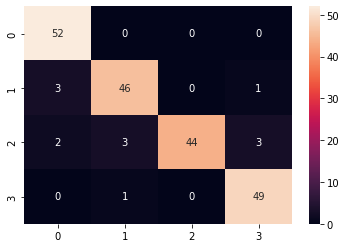

In [ ]:
#Print overall accuracy
from sklearn import metrics
#print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
report = metrics.classification_report(test_labels, prediction)
print(report)
cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 41ms/step
The prediction for this image is:  ['Eczema']


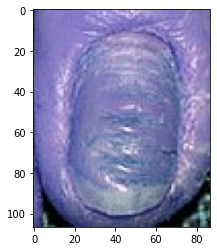

In [ ]:
#Test model
img = cv2.imread("/content/drive/MyDrive/eczema.jpg", cv2.IMREAD_COLOR)   
plt.imshow(img)
img = cv2.resize(img, (SIZE, SIZE))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = img/255.0
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])